## General Imports

In [27]:
import pandas as pd
import numpy as np
np.random.seed(42)

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Update wanrnings to not print source line
import warnings

def custom_formatwarning(msg, *args, **kwargs):
    # ignore everything except the message
    return str(msg) + '\n'

warnings.formatwarning = custom_formatwarning

## Load Data, Split Train-Val, and Train Model

For the purpose of this examples we'll use the simple iris dataset and train a random forest model for multiclass classification

In [28]:
iris_df = load_iris(return_X_y=False, as_frame=True)['frame']
label_col = 'target'
df_train, df_test = train_test_split(iris_df, stratify=iris_df[label_col], random_state=0)

In [29]:
rf_clf = RandomForestClassifier()
rf_clf.fit(df_train.drop(label_col, axis=1), df_train[label_col])

RandomForestClassifier()

## Define MLChecks Dataset

In [30]:
from deepchecks import Dataset

Initialize the Dataset object, stating the relevant metadata about the dataset (e.g. the name for the label column) <br>
Check out the Dataset's attributes to see which additional special columns can be declared and used (e.g. index, date).

In [31]:
# We explicitly state that this dataset has no categorical features, otherwise they will be automatically inferred

ds_train = Dataset(df_train, label = label_col)
ds_test =  Dataset(df_test, label = label_col)

## Run Overall Generic Check Suite

In [32]:
from deepchecks.suites import OverallGenericCheckSuite


Overall Generic Suite 
 The suite is composed of various checks such as: Data Sample Leakage Report, Single Feature Contribution, Single Feature Contribution Train Test, etc... 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ), as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

Status,Check,Condition,More Info
✓,Data Sample Leakage Report,Percentage of test data samples that appear in train data not greater than 10.00%,
✓,Naive Model Comparison,Ratio not less than 1.1 between the given model's result and the naive model's result,
✓,Mixed Nulls - Train Dataset,Not more than 1 different null types for all columns,
✓,Mixed Nulls - Test Dataset,Not more than 1 different null types for all columns,
✓,Mixed Types - Train Dataset,Rare type ratio is not less than 1.00% of samples in all columns,
✓,Mixed Types - Test Dataset,Rare type ratio is not less than 1.00% of samples in all columns,
✓,String Mismatch - Train Dataset,No string variants for all columns,
✓,String Mismatch - Test Dataset,No string variants for all columns,
✓,Rare Format Detection - Train Dataset,Rare formats ratio upper bound,
✓,Rare Format Detection - Test Dataset,Rare formats ratio upper bound,


Additional Outputs

Data Sample Leakage Report

Detect samples in the test data that appear also in training data.

2.63% (1.0 / 38) of test data samples appear in train data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
Test indices: 142,5.80,2.70,5.10,1.90,2
Train indices: 101,5.80,2.70,5.10,1.90,2


Single Feature Contribution - Train Dataset

Return the PPS (Predictive Power Score) of all features in relation to the label.

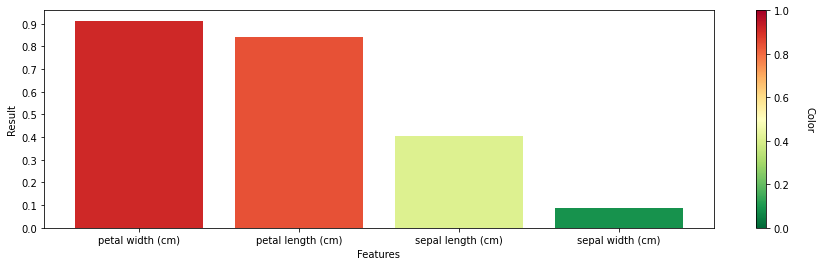

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

Single Feature Contribution - Test Dataset

Return the PPS (Predictive Power Score) of all features in relation to the label.

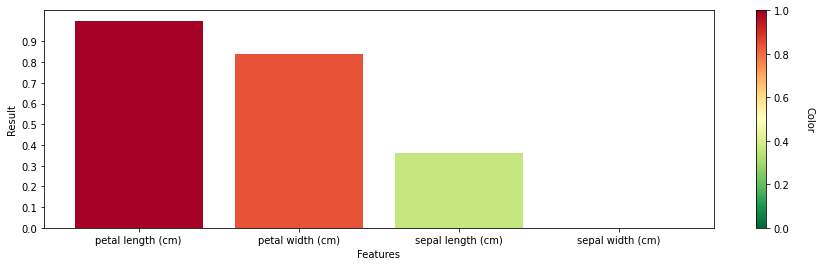

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

Single Feature Contribution Train-Test

Return the difference in PPS (Predictive Power Score) of all features between train and test datasets.

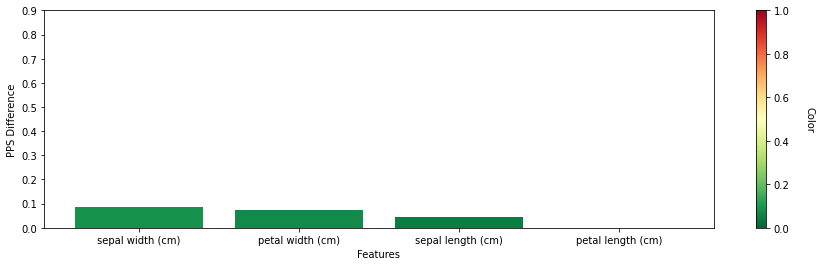

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

When we compare train PPS to test PPS, A high difference can strongly indicate leakage, as a feature

that was powerful in train but not in test can be explained by leakage in train that is not relevant to a new dataset.

Train Test Difference Overfit

Visualize overfit by displaying the difference between model metrics on train and on test data.

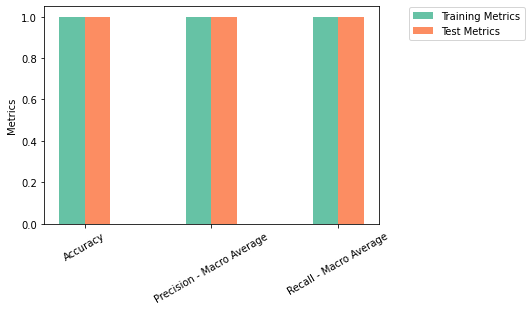

Performance Report - Train Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision - Macro Average,1.00
Recall - Macro Average,1.00


Performance Report - Test Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision - Macro Average,1.00
Recall - Macro Average,1.00


Naive Model Comparison

Compare naive model score to given model score.

The given model performs 2.92 times compared to the naive model using the Accuracy metric. RandomForestClassifier model prediction has achieved a score of 1 compared to Naive statistical prediction which achieved a score of 0.34 on tested data.

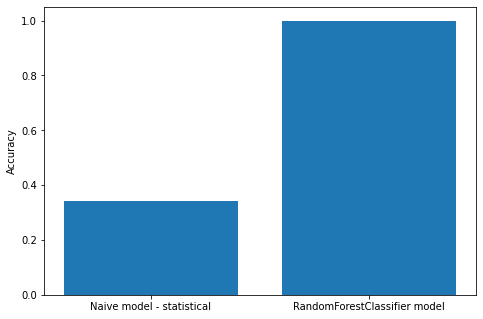

Check,Reason
Boosting Overfit,DeepchecksValueError: Unsupported model of type: RandomForestClassifier
Special Characters - Test Dataset,Nothing found
Special Characters - Train Dataset,Nothing found
Rare Format Detection - Test Dataset,Nothing found
Rare Format Detection - Train Dataset,Nothing found
Data Duplicates - Test Dataset,Nothing found
Data Duplicates - Train Dataset,Nothing found
String Mismatch Comparison,Nothing found
String Mismatch - Test Dataset,Nothing found
Mixed Types - Test Dataset,Nothing found


In [33]:
OverallGenericCheckSuite.run(train_dataset=ds_train, test_dataset=ds_test, model=rf_clf, check_datasets_policy='both')

## Let's see what would've happened with a different train-val split:

In [34]:
train_len = round(0.67*iris_df.shape[0])
alternative_train_df = Dataset(iris_df[:train_len], label = label_col)
alternative_test_df = Dataset(iris_df[train_len:], label = label_col)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Overall Generic Suite 
 The suite is composed of various checks such as: Data Sample Leakage Report, Single Feature Contribution, Single Feature Contribution Train Test, etc... 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ), as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

Status,Check,Condition,More Info
✓,Data Sample Leakage Report,Percentage of test data samples that appear in train data not greater than 10.00%,
✓,Naive Model Comparison,Ratio not less than 1.1 between the given model's result and the naive model's result,
✓,Mixed Nulls - Train Dataset,Not more than 1 different null types for all columns,
✓,Mixed Nulls - Test Dataset,Not more than 1 different null types for all columns,
✓,Mixed Types - Train Dataset,Rare type ratio is not less than 1.00% of samples in all columns,
✓,Mixed Types - Test Dataset,Rare type ratio is not less than 1.00% of samples in all columns,
✓,String Mismatch - Train Dataset,No string variants for all columns,
✓,String Mismatch - Test Dataset,No string variants for all columns,
✓,Rare Format Detection - Train Dataset,Rare formats ratio upper bound,
✓,Rare Format Detection - Test Dataset,Rare formats ratio upper bound,


Additional Outputs

Single Feature Contribution - Train Dataset

Return the PPS (Predictive Power Score) of all features in relation to the label.

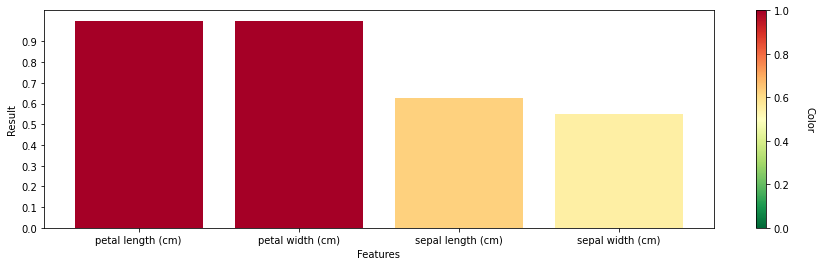

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

Single Feature Contribution - Test Dataset

Return the PPS (Predictive Power Score) of all features in relation to the label.

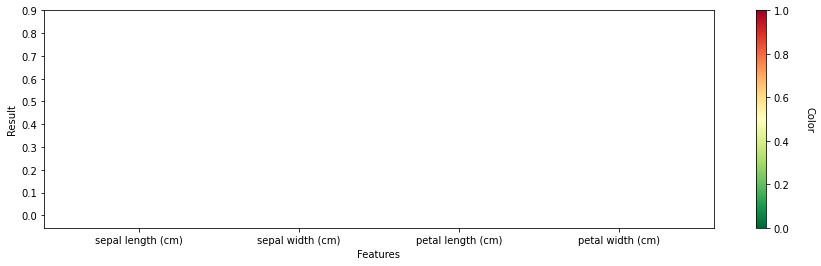

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

Single Feature Contribution Train-Test

Return the difference in PPS (Predictive Power Score) of all features between train and test datasets.

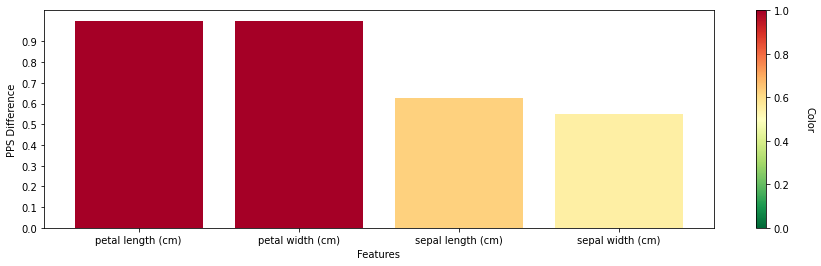

The PPS represents the ability of a feature to single-handedly predict another feature or label.

A high PPS (close to 1) can mean that this feature's success in predicting the label is actually due to data

leakage - meaning that the feature holds information that is based on the label to begin with.

When we compare train PPS to test PPS, A high difference can strongly indicate leakage, as a feature

that was powerful in train but not in test can be explained by leakage in train that is not relevant to a new dataset.

Train Test Difference Overfit

Visualize overfit by displaying the difference between model metrics on train and on test data.

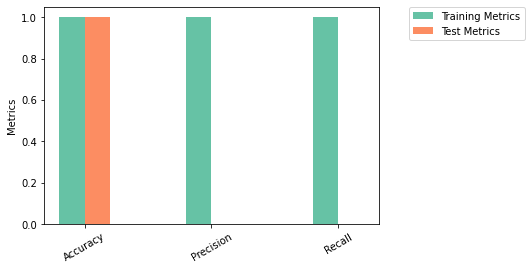

Performance Report - Train Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision,1.00
Recall,1.00


Performance Report - Test Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision,0.00
Recall,0.00


Naive Model Comparison

Compare naive model score to given model score.

The given model performs 10 times compared to the naive model using the Accuracy metric. RandomForestClassifier model prediction has achieved a score of 1 compared to Naive statistical prediction which achieved a score of 0 on tested data.

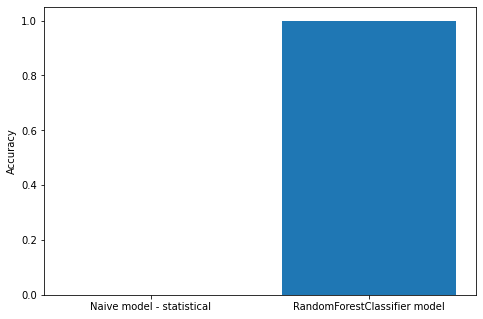

Single Value in Column - Test Dataset

Check if there are columns which have only a single unique value in all rows.

The following columns have only one unique value

,target
Single unique value,2


Data Duplicates - Test Dataset

Search for duplicate data in dataset.

2.00% of data samples are duplicates

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
Number of Duplicates,,,,,
2,5.80,2.70,5.10,1.90,2


Check,Reason
Boosting Overfit,DeepchecksValueError: Unsupported model of type: RandomForestClassifier
Data Sample Leakage Report,Nothing found
Single Value in Column - Train Dataset,Nothing found
Mixed Nulls - Train Dataset,Nothing found
Mixed Nulls - Test Dataset,Nothing found
Mixed Types - Train Dataset,Nothing found
Mixed Types - Test Dataset,Nothing found
String Mismatch - Train Dataset,Nothing found
String Mismatch - Test Dataset,Nothing found
Data Duplicates - Train Dataset,Nothing found


In [35]:
OverallGenericCheckSuite.run(train_dataset=alternative_train_df, test_dataset=alternative_test_df,
                             model=rf_clf, check_datasets_policy='both')

##### Note that we found:
1. Validation Dataset 'target' column, which is the label column, had only one single unique value! This indicates something that's worth noticing (validation data is different than the training data and has only a single type of labels in samples...)
2. Validation dataset had a duplicate sample (which might be fine, use-case dependent). If not relevant, this check can be removed from suite.

## Create Custom CheckSuite

In [36]:
from deepchecks import CheckSuite
from deepchecks.checks import *

In [37]:
# check out which builtin performance checks exist
print([class_name for class_name in dir(performance) if class_name[0].isupper()])

['CalibrationMetric', 'ConfusionMatrixReport', 'NaiveModelComparison', 'PerformanceReport', 'RocReport', 'SegmentPerformance']


In [38]:
MyModelSuite = CheckSuite('Simple Suite For Model Performance',
    ModelInfo(),
    PerformanceReport(),
    TrainTestDifferenceOverfit(),
    ConfusionMatrixReport(),
    NaiveModelComparison(),
    NaiveModelComparison(naive_model_type='statistical')
)

Simple Suite For Model Performance 
 The suite is composed of various checks such as: Model Info, Performance Report, Train Test Difference Overfit, etc... 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ), as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

No conditions defined on checks in the suite.

Additional Outputs

Model Info

Summarize given model parameters.

Model Type: RandomForestClassifier

,parameter,value
0,bootstrap,True
1,ccp_alpha,0.00
2,class_weight,None
3,criterion,gini
4,max_depth,None
5,max_features,auto
6,max_leaf_nodes,None
7,max_samples,None
8,min_impurity_decrease,0.00
9,min_samples_leaf,1


Performance Report - Train Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision - Macro Average,1.00
Recall - Macro Average,1.00


Performance Report - Test Dataset

Summarize given metrics on a dataset and model.

,Score
Metric,
Accuracy,1.00
Precision - Macro Average,1.00
Recall - Macro Average,1.00


Train Test Difference Overfit

Visualize overfit by displaying the difference between model metrics on train and on test data.

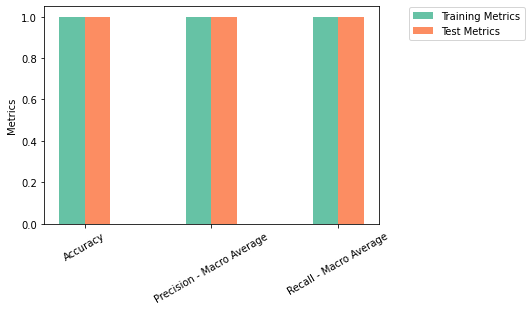

Confusion Matrix Report - Train Dataset

Calculate the confusion matrix of the model on the given dataset.

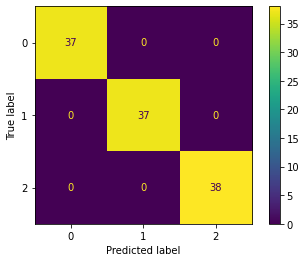

Confusion Matrix Report - Test Dataset

Calculate the confusion matrix of the model on the given dataset.

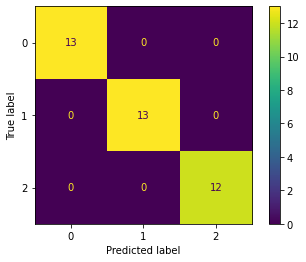

Naive Model Comparison

Compare naive model score to given model score.

The given model performs 2.92 times compared to the naive model using the Accuracy metric. RandomForestClassifier model prediction has achieved a score of 1 compared to Naive statistical prediction which achieved a score of 0.34 on tested data.

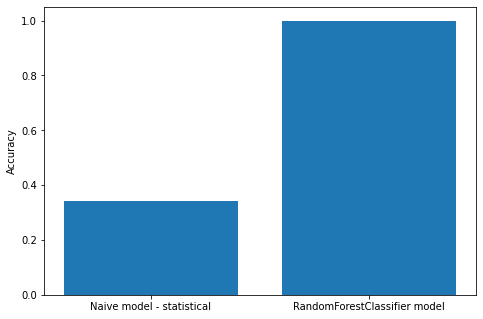

Naive Model Comparison

Compare naive model score to given model score.

The given model performs 2.92 times compared to the naive model using the Accuracy metric. RandomForestClassifier model prediction has achieved a score of 1 compared to Naive statistical prediction which achieved a score of 0.34 on tested data.

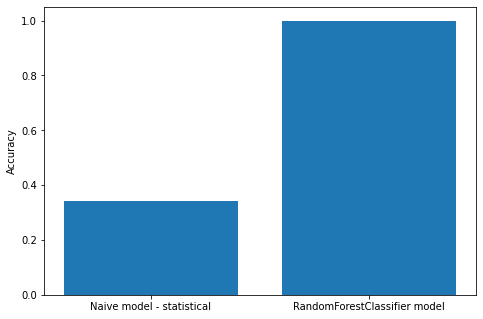

In [39]:
MyModelSuite.run(model=rf_clf, train_dataset=ds_train, test_dataset=ds_test, check_datasets_policy='both')